In [2]:
from dask.distributed import Client
from dask.array import coarsen
from fish.image.zds import ZDS
import dask.array as da
import numpy as np

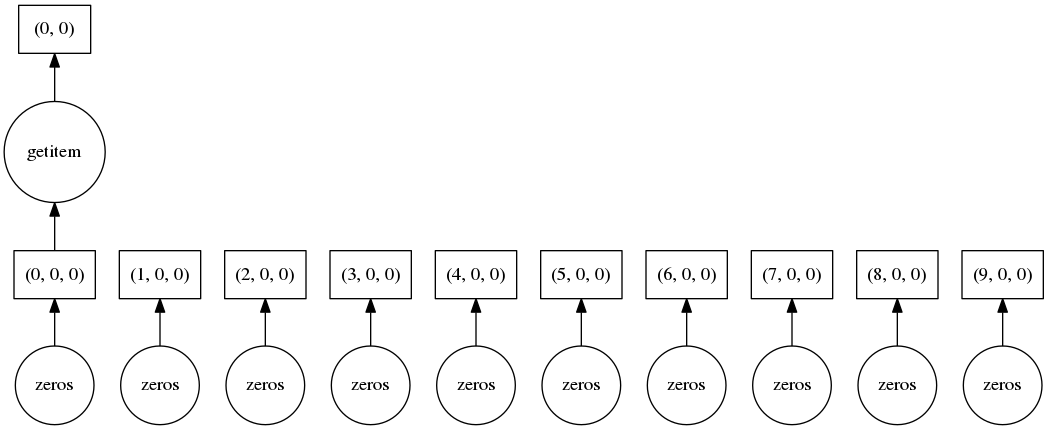

In [11]:
test = da.zeros([10,2,2], chunks=(1,'auto','auto'))
test[0].visualize()

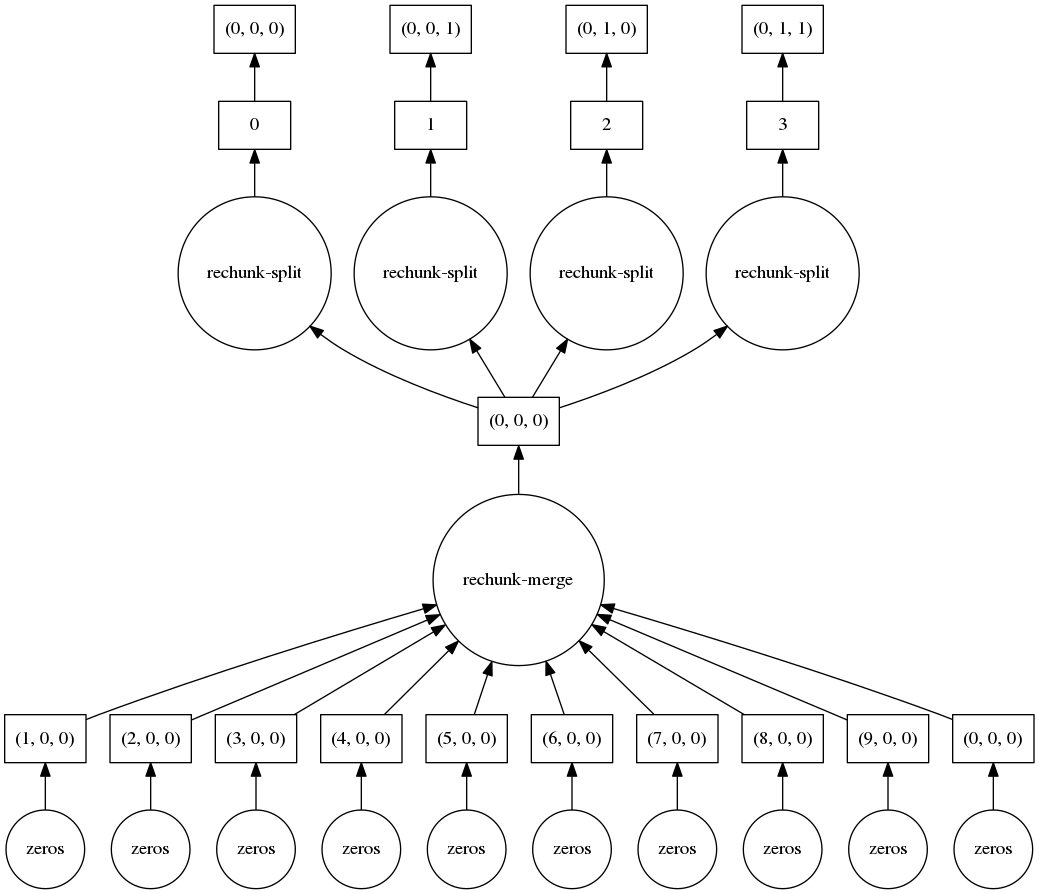

In [12]:
rechunked = test.rechunk((test.shape[0],1,1))
rechunked.visualize()

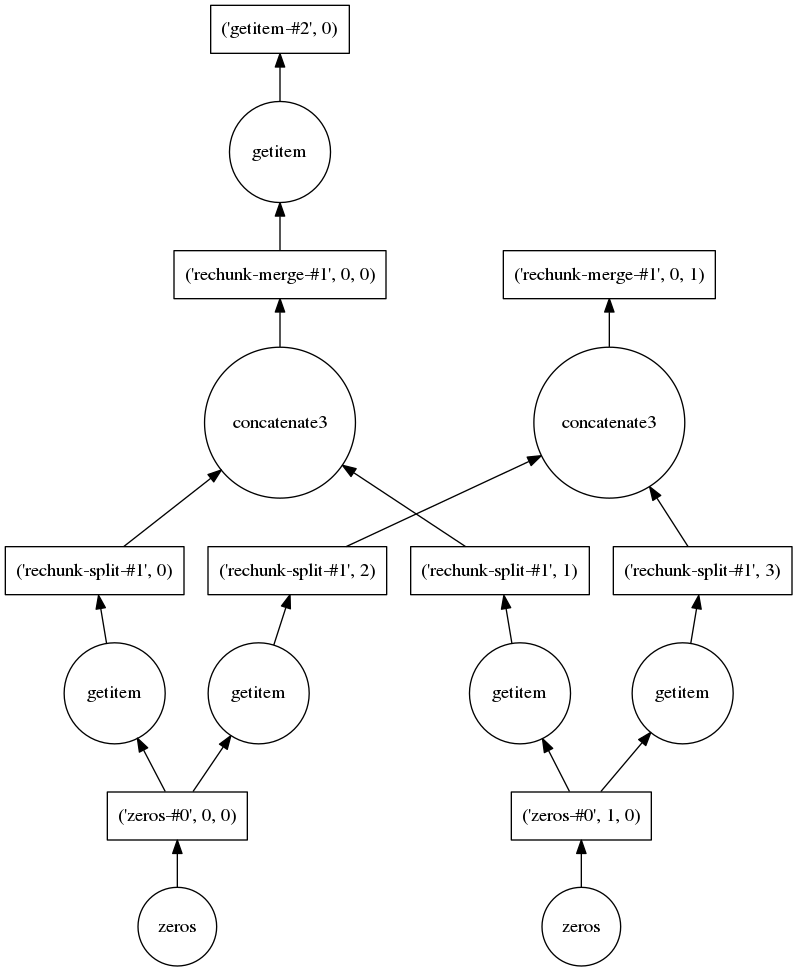

In [31]:
rechunked[:,0].visualize()

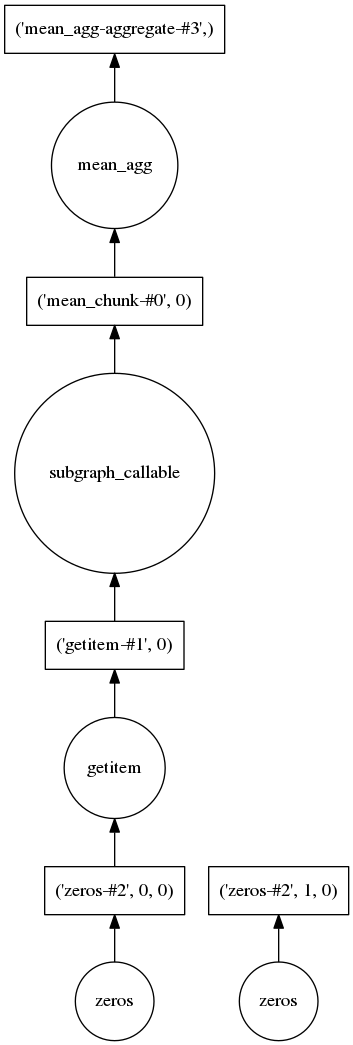

In [30]:
test[0].mean(0).visualize()

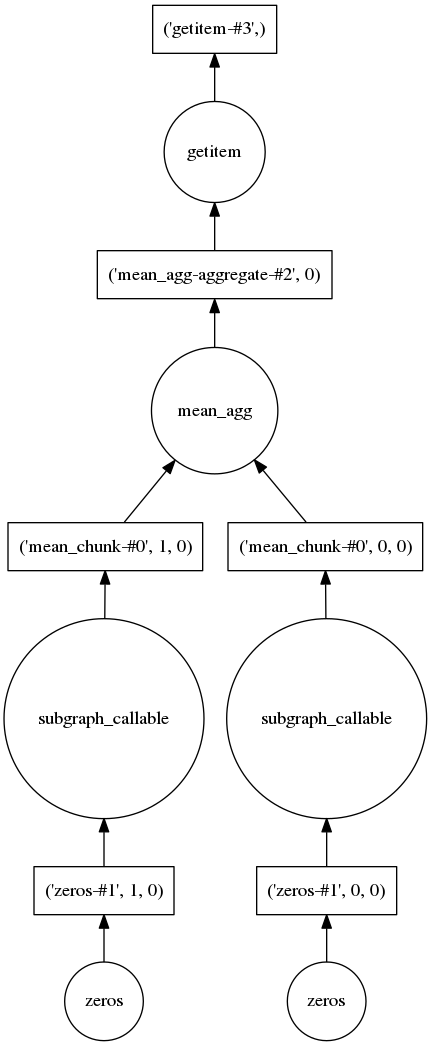

In [29]:
test.mean(0)[0].visualize()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
base_dirs = ('/nrs/ahrens/davis/data/spim/raw/20160212/7dpf_cy163xcy203_spon_1_20160212_182853/',)

In [4]:
base_dir = base_dirs[0]
reg_path = base_dir.replace('raw', 'proc') + 'reg/regparams_affine.npy'
dset = ZDS(base_dir)
data=dset.data
fps = dset.metadata['volume_rate']
try: 
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    shifts = None    
    print('No valid regparams found. They will be estimated')
data.shape

No valid regparams found. They will be estimated


(3000, 41, 2048, 2048)

In [8]:
%%timeit
from fish.util.fileio import read_image
read_image(dset.files[-1])

1.98 s ± 59.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
dset.data[-1].compute()

2.19 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fps
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation    
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

In [6]:
ref = data[:5].mean(0).astype('int16')

In [13]:
chunkgen = (x for x in data[:40].blocks)
tmp_r = [t for t in client.map(lambda a: a + 10, chunkgen)]

In [ ]:
from dask.array import map_blocks

In [152]:
from icecream import ic

In [238]:
data.max('time')

(3000, 41, 2048, 2048)

In [239]:
data.shape

(3000, 41, 2048, 2048)

In [180]:
def dask_reg(data, reference, prefilter, transform_type='translation'):
    """
    data: a dask array distributed along the first axis
    reference: a dask array representing the reference image
    prefilter: a function on a numpy array that will be mapped to each block in data
    transform_type: the transformation type to estimate. Currently defaults to "translation"

    returns a dask array which, when computed, will return an affine matrix per timepoint
    """

    from dask.array import map_blocks        
    
    def 
    
    if transform_type=='translation':
        from fish.image.alignment import estimate_translation
        transformer = estimate_translation
        def transformer(fixed, moving):
            return np.ones([1,3,3], dtype='float32')
    
    sample_filt = prefilter(data)[0].compute(scheduler='threads')

    if sample_filt.ndim != data.ndim-1:
        drop_ = (data.ndim - 1) - sample_filt.ndim
        drop = tuple(range(data.ndim))[-drop_:]
        ic(drop)
        
    data_filt = data.map_blocks(prefilter, dtype=sample_filt.dtype, drop_axis=drop, chunks=(1, *sample_filt.shape))

    
    aff_shape = (3,3)
    if len(aff_shape) != data_filt.ndim - 1:
        drop_reg = (data_filt.ndim - 1) - len(aff_shape)
        drop_reg = tuple(range(data_filt.ndim))[-drop_:]
    else:
        drop_reg = None
    ic(reference)
    data_reg = map_blocks(transformer, 
                          reference, 
                          data_filt, 
                          chunks=(1,3,3), 
                          drop_axis=drop_reg,
                          dtype='float32')

    return data_reg 


In [181]:
prefilter = lambda v: v.max(1)
reference = prefilter(data[0])

In [182]:
dask_reg(data, reference, prefilter)[1].compute()

ic| drop: (3,)
ic| reference: dask.array<amax-aggregate, shape=(41, 2048), dtype=int16, chunksize=(41, 2048)>
ic| fixed.shape: (41, 2048)
ic| moving.shape: (1, 2048, 2048)


array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [10]:
cluster = get_cluster()
cluster.adapt()
client = Client(cluster)
client

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://10.36.110.32:43459 Dashboard: http://10.36.110.32:45989/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [18]:
ds_xy = 2
data_ds = coarsen(np.mean, data[roi], {2: ds_xy, 3: ds_xy}).astype(data.dtype).max(1)

In [ ]:
result = data_ds.compute()

In [20]:
flw(result)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]
